### Brain Age Prediction using Deep Neural Network with PyTorch

In [1]:
import numpy as np
import pandas as pd
import random as rn

import matplotlib.pyplot as plt
#from keras.callbacks import TensorBoard

from plotnine import * # a Grammar of Graphics for Python, aka ggplot2 in R

import time
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, linear_model

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [2]:
# Load data
dat = np.load('./full_reduced/full/feaDAT.npy')
age = np.load('./full_reduced/full/ageDAT.npy')
sex = np.load('./full_reduced/full/sexDAT.npy')

In [3]:
# 'cmd /' to comment on/off
X = preprocessing.scale(dat)

In [4]:
X.shape

(2026, 5124)

In [5]:
#Splitting into Training set and Test set, X, Y pair
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, age, test_size = 0.2, random_state = 42)

In [6]:
X_train1 = Variable(torch.from_numpy(X_train))
Y_train1 = Variable(torch.from_numpy(Y_train))
X_train1 = X_train1.float()
Y_train1 = Y_train1.float()

X_test1 = Variable(torch.from_numpy(X_test))
X_test1 = X_test1.float()

In [7]:
torch.manual_seed(999)    # reproducible
# model setup
n_hidden = 50
class Model(torch.nn.Module): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(X.shape[1], 500)
        self.layer2 = nn.Linear(500, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_hidden)
        self.layer4 = nn.Linear(n_hidden, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
        # self.dropout = nn.Dropout(0.5)  
            
    def forward (self, x):
        out1 = self.sigmoid(self.layer1(x))
        out2 = self.sigmoid(self.layer2(out1))
        out3 = self.sigmoid(self.layer3(out2))
        y_pred = self.layer4(out3) # linear output
        return y_pred
    
net = Model()

In [8]:
criterion = nn.MSELoss()# Mean Squared Loss
l_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), 
                            lr = l_rate, 
                            weight_decay=1e-6) 
#                             momentum=0.9, 
#                             nesterov=True) #Stochastic Gradient Descent

epochs = 500 # 

In [9]:
inputs = X_train1
labels = Y_train1.view(Y_train.shape[0],1)
# Collect errors to evaluate performance
errorlist = [];
for epoch in range(epochs):

    #increase the number of epochs by 1 every time
    epoch +=1
    
    #clear grads 
    optimizer.zero_grad()
    #forward to get predicted values
    outputs = net(inputs) # model predict,  outputs = net.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()# back props
    optimizer.step()# update the parameters 
    
    errorlist = np.append(errorlist,loss.item()) 
    
    if epoch % 100 == 0:
        print('epoch {}, loss {:.2f}'.format(epoch,loss.data))
        

epoch 100, loss 297.25
epoch 200, loss 112.18
epoch 300, loss 41.85
epoch 400, loss 23.34
epoch 500, loss 15.03


In [10]:
y_train_pred = net(X_train1)
y_train_pred = y_train_pred.detach().numpy()
corr_train = np.corrcoef(Y_train, y_train_pred.flatten())[0,1]
print("Train data correlation %.3f " % corr_train)

Train data correlation 0.984 


In [11]:
X_prediction = net(X_test1)
X_prediction = X_prediction.detach().numpy()
corr_test = np.corrcoef(Y_test, X_prediction.flatten())[0,1]
print("Test data correlation %.3f " % corr_test)

Test data correlation 0.928 


In [12]:
mean_absolute_error(Y_test, X_prediction)

5.752950768700962

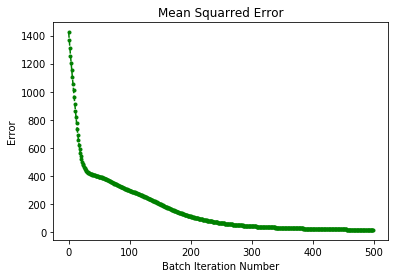

In [13]:
plt.plot(errorlist,'--.g')
plt.title("Mean Squarred Error")
plt.xlabel("Batch Iteration Number")
plt.ylabel("Error")
plt.show()

[min, median, max] age: [6 25 88] years


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


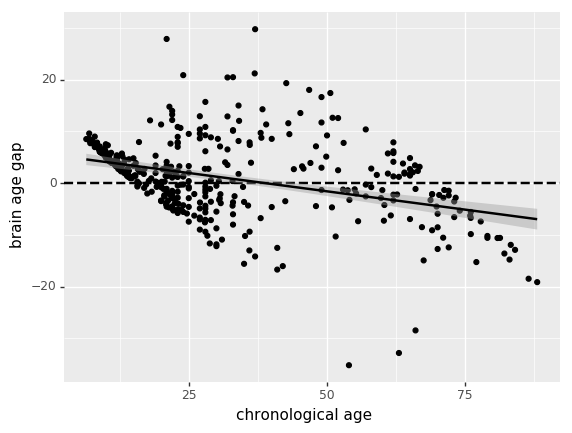

<ggplot: (334191315)>


In [14]:
# bias shown in brain age gap: over/under-estimate for lower/upper ends
idx = np.argsort(Y_test)
age_gap = X_prediction.flatten() - Y_test
dframe = pd.DataFrame()
dframe['age_gap'] = age_gap
dframe['Y_test'] = Y_test
p2 = ggplot(dframe, aes('Y_test','age_gap')) + geom_point() +\
    geom_hline(yintercept=[0], size=1, linetype='--') +\
    xlab('chronological age') +\
    ylab('brain age gap') +\
    stat_smooth(method='lm') 
  
print("[min, median, max] age: [%d %d %d] years" % (min(Y_test), np.median(Y_test), max(Y_test)))
print(p2) 